### Training a Feature classifier model to classify chop-shops in aerial imagery

## Objective: obtain better results after SSD detection

after running the detection, we found that with padding = 1, the model provided good results in detecting chopshop.

### We did, however, found some issues that needed to be addressed:
1. **chop shop class** - on lower confidence level, the model had some false positives, and threshold above 40% was needed <br>
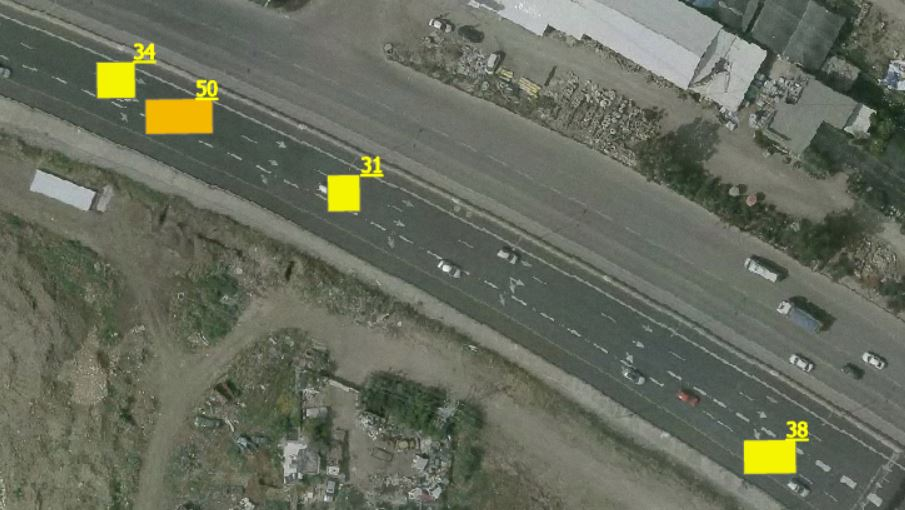
<br>
2. Some chop-shops were **mistakenly classified** as parking places <br>
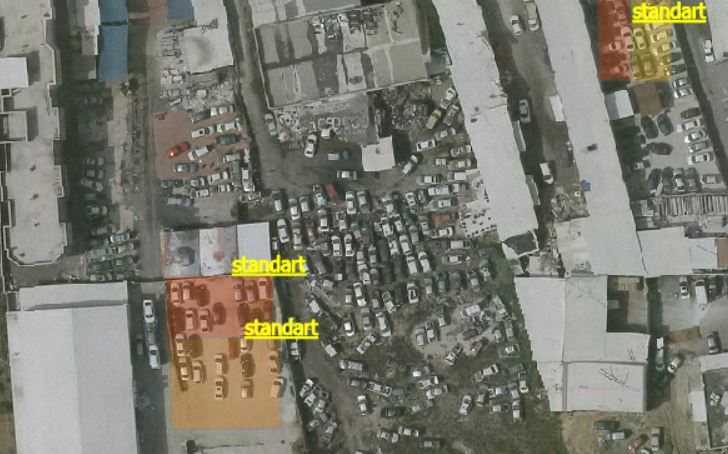 
<br>
3. **parking class** - Many false positive detections (around 30%) <br>
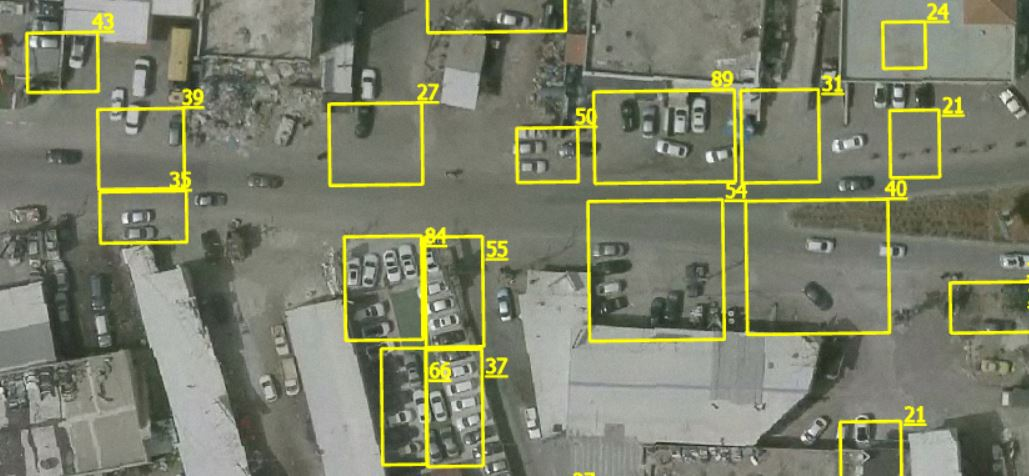



# Solution:
#### In order to determine what features that was detected as parking class, are actually chopShops, we trained a __feature classification__ model.

> #### The model should be able to detect between chop shops, parking and background.
> #### After training the model we will run a detection **only on relavant features** who has high potential to be confused between the classes.

<br></br>
# *Process*
***
1. #### Create and export samples using **Training Samples Manager**
2. #### Training feature classifier model
3. #### analyze the result layer to deceide on which feature to detect
4. #### detect features and analyze results



# Training Feature Classifier model
###  create new samples for detection:
>#### The samples that would be exported for the FC model, are features from the results layer of the SSD model.
>#### They would have edges with unrelavant data.
>#### We needed to make sure that the samples contain background around the center target.
<table><tr>
<td> 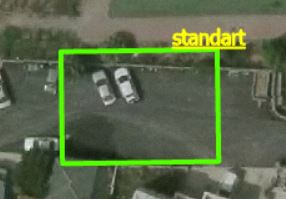 </td>
    <td></td><td></td> <td></td><td></td>
<td> 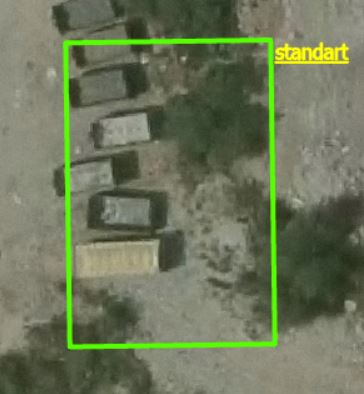 </td>
    <td></td><td></td> <td></td><td></td>
<td> 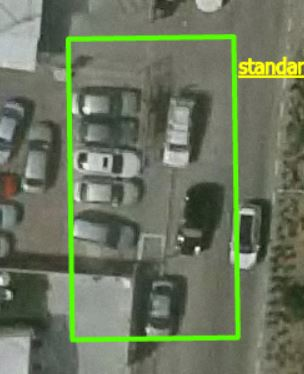 </td>
</tr></table>





##  Export training samples process
***



###  Export samples with Export Training Data For Deep Learning tool


#### using pyplotlib to display samples distribution

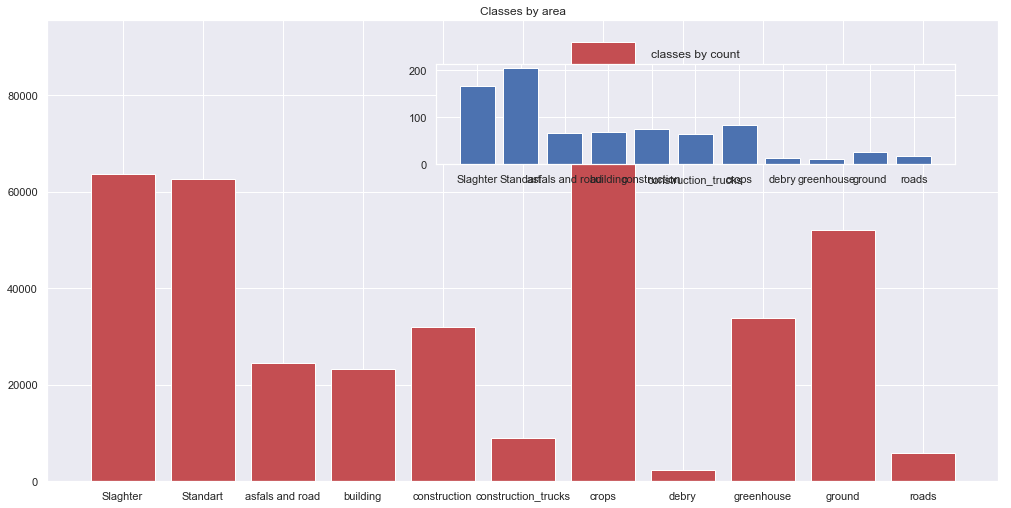

In [628]:
#calling the sample layer and check the distribution
samples_layer,map1 = Access_and_view_layer(layerName = r"C:\Users\urial\DeepLearningProjects\mashhetot\mashhetot.gdb\SamplesAllLabelsNorthA")
plot_layer(samples_layer)

#### Export training samples using "Export Training Data For Deep Learning"  arcgis pro's tool, from inside the notebook

In [642]:

exportTrainingSamplesFC(in_raster=r'\\gis-rocket\e$\Kenes2019\ML\Ortophoto examples.ecw',
                        outLocation = r'C:\Users\urial\DeepLearningProjects\slaghters\presentation\FC\Training\FC_Train',
                        input_layer="SamplesAllLabelsNorthA" )

Export training samples completed 
 the output location:
C:\Users\urial\DeepLearningProjects\slaghters\presentation\FC\Training\FC_Train\samples

Checking for appropriate file structure...

the file: esri_accumulated_stats.json found in folder
the file: esri_model_definition.emd found in folder
the file: images found in folder
the file: labels found in folder
the file: map.txt found in folder
the file: stats.txt found in folder


## Training feature classifier Process
***

In [644]:
data_path = r"C:\Users\urial\DeepLearningProjects\slaghters\presentation\FC\Training\FC_Train\samples"
class_mapping_all={1:'standart parking',2:'chop shop', 3:'background',4:'background',5:'background',6:'background',7:'background',8:'background',10:'background',11:'background',12:'background'}

data = prepare_data(path = data_path,
                    class_mapping=class_mapping,
                    chip_size=chip_size,
                    batch_size=batch_size) #small batch size because of CUDA memory issues



In [645]:
data.classes

['background', 'slaghters', 'standart parking']

In [647]:
model = FeatureClassifier(data) #calling feature classifier model

In [649]:

model.fit(4, lr = 2e-02,checkpoint=True,early_stopping=True) 

epoch,train_loss,valid_loss,accuracy
1,0.980038,1.240413,0.587500
2,0.991721,0.673519,0.750000
3,0.795214,0.363443,0.875000
4,0.651729,0.383332,0.812500


In [652]:
model.fit(4, lr= 1e-03,checkpoint=True,early_stopping=True) 

epoch,train_loss,valid_loss,accuracy
1,0.599984,0.302852,0.900000
2,0.586386,0.326980,0.900000
3,0.561704,0.311350,0.912500
4,0.507524,0.307207,0.912500


In [654]:
model.save('FC_8ep')

WindowsPath('C:/Users/urial/DeepLearningProjects/slaghters/presentation/FC/Training/FC_Train/samples/models/FC_8ep')

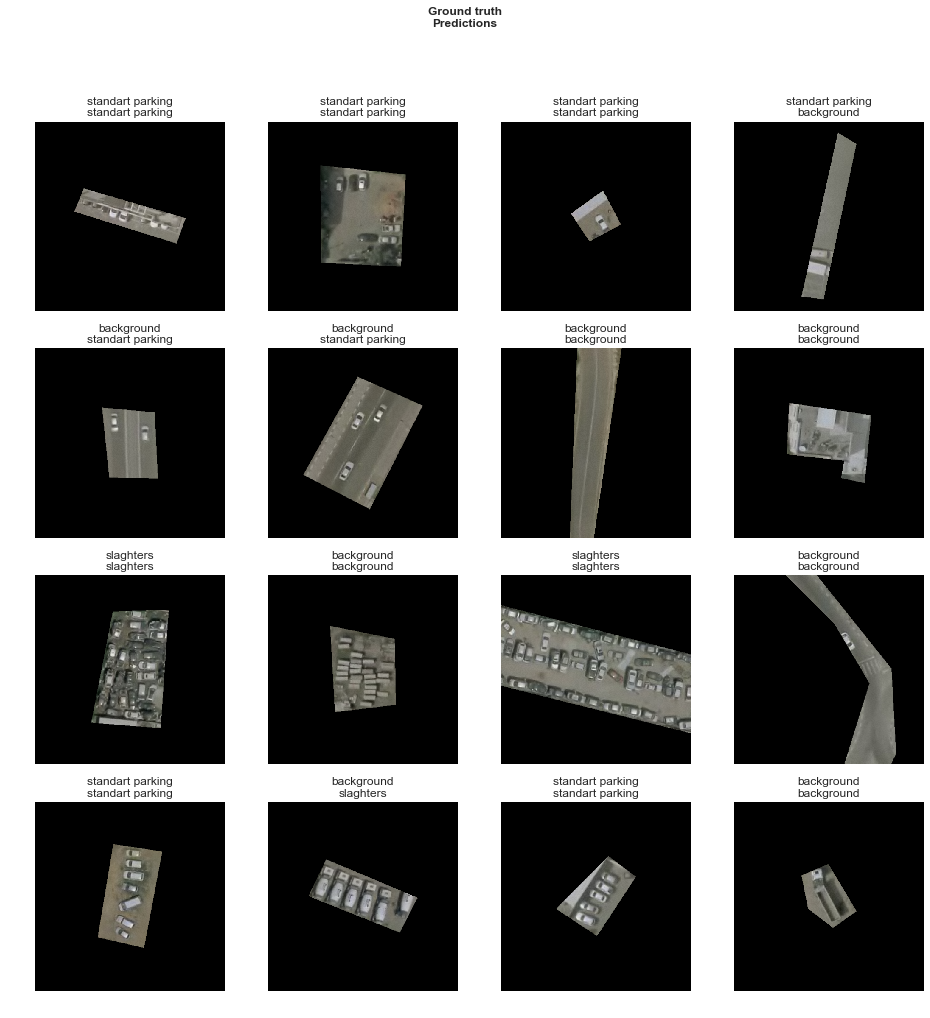

In [656]:
model.show_results(rows=4)

# Examine SSD results
***
###  Because we found that high confidence observations of the chop shop class are accurate, we wanted to find their pattern, and extract that same pattern from the parking layer
### We will run an FC detection only on those relavant features



####  *Calling SSD initial result layer, using arcgis.learn.GeoAccessor / SpatialDataFrame to work in pandas like enviroment*

In [482]:
pre_layer = import_layer(r"C:\Users\urial\DeepLearningProjects\mashhetot\mashhetot.gdb\Ortophotoexamples_DetectObje4",'OID')

OID set as index


#### Using Seaborn library to display distributions:

>1. Find pattern of high confidence of Chop-shop class
>2. Use this pattern to decide which features to extract from parking places, 


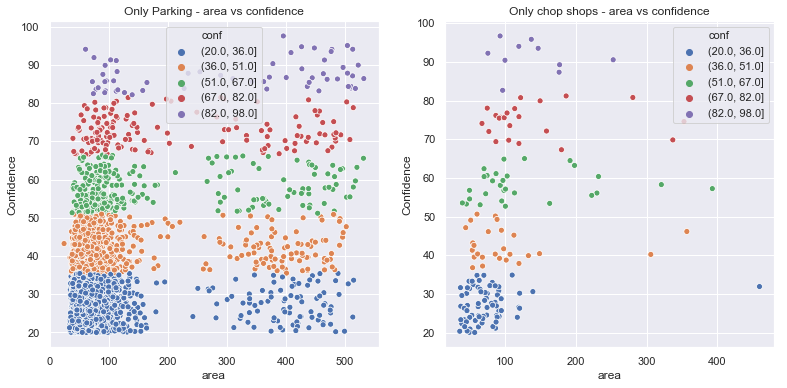

In [658]:
maskA = (pre_layer['Class']=='slagh')
mask = (pre_layer1['Class']=='standart')
fig, ax =plt.subplots(1,2,figsize=(13,6))
ax[0].set_title('Only Parking - area vs confidence')
ax[1].set_title('Only chop shops - area vs confidence')
sns.scatterplot(x='area',y='Confidence',hue = 'conf',data=pre_layer[mask], ax=ax[0])
sns.scatterplot(x='area',y='Confidence',hue = 'conf',data=pre_layer[maskA], ax=ax[1])
plt.show()



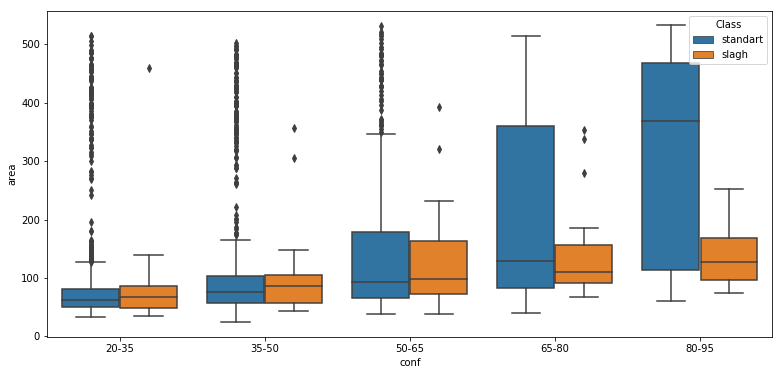

In [237]:
plt.figure(figsize=(13,6))
ax = sns.boxplot(x='conf',y='area', hue='Class',data=pre_layer1)

### *features that are between 100 and 300 Sq m, are more likly to have good confidence in the chopShop class*

In [665]:
maskPark= ((pre_layer.Confidence>35) & (pre_layer.Class_values==1) & ((pre_layer.area>100) & (pre_layer.area<375)))
maskChop = (pre_layer.Class_values==2)
mask = maskPark | maskChop

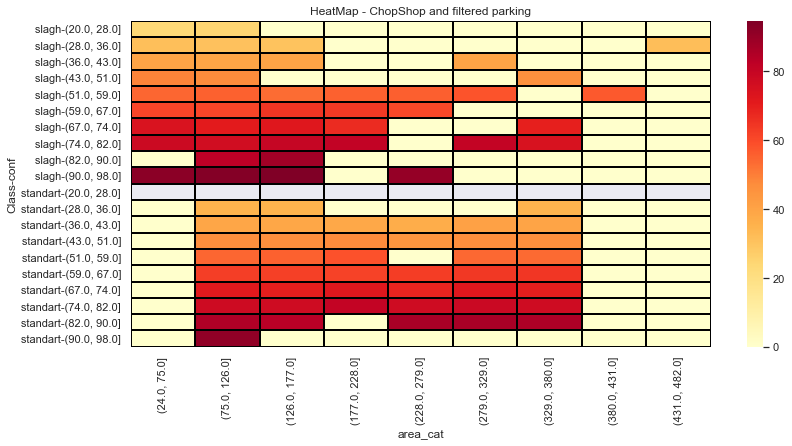

In [670]:
heatlayer = pre_layer[mask].assign(conf = pd.cut(pre_layer['Confidence'],10,precision=0))\
.assign(area_cat = pd.cut(pre_layer['area'],10,precision =0))

heat = heatlayer.pivot_table(values='Confidence',
    index=['Class','conf'],
    columns='area_cat').groupby(['Class','conf']).sum()

plt.figure(figsize=(13,6))
ax = sns.heatmap(heat,cmap = 'YlOrRd',linewidths=1,linecolor='Black').set_title('HeatMap - ChopShop and filtered parking')

# Preapering export data for detecting
***

### 1. *Using GeoAccessor and SpatialDataFrame to filter the layer*

In [677]:
maskPark= ((pre_layer.Confidence>35) & (pre_layer.Class_values==1) & ((pre_layer.area>100) & (pre_layer.area<375)))
maskChop = (pre_layer.Class_values==2) & (pre_layer.Confidence>=40)
mask = maskPark | maskChop
FC_detection_layer = pre_layer[maskPark].drop(columns = ['conf']).copy()
FC_chopShops = pre_layer[maskChop].drop(columns = ['conf']).copy()

In [678]:
FC_detection_layer.head(3)

,Class,Confidence,SHAPE,area,Class_values
OID,,,,,
5,standart,36.830840,"{""rings"": [[[194514.1507127462, 669562.2339522...",349.511198,1
225,standart,50.269914,"{""rings"": [[[195584.02822739352, 669539.333549...",369.664735,1
226,standart,42.217717,"{""rings"": [[[195603.53959214035, 669544.048112...",354.428726,1


In [682]:
#export only cars for detection
exportAgol(in_layer_var = FC_detection_layer,
           out_layer_name = 'parking_FC_detection')

GDB path is: C:\Users\urial\DeepLearningProjects\mashhetot\mashhetot.gdb\parking_FC_detection
SHP path is: C:\Users\urial\DeepLearningProjects\slaghters\presentation\FC\Detect\agol_export\parking_FC_detection.shp


### 2. *Export  samples for detection*


In [683]:
#export detection samples and create unique num field 
exportTrainingSamplesFC(in_raster =r'\\gis-rocket\e$\Kenes2019\ML\Ortophoto examples.ecw',
                        outLocation = r'C:\Users\urial\DeepLearningProjects\slaghters\presentation\FC\Detect\filtered_cars_FC',
                        input_layer = r'C:\Users\urial\DeepLearningProjects\mashhetot\mashhetot.gdb\parking_FC_detection',
                        class_value_field = 'Unique_num')

Export training samples completed 
 the output location:
C:\Users\urial\DeepLearningProjects\slaghters\presentation\FC\Detect\filtered_cars_FC\samples

Checking for appropriate file structure...

the file: esri_accumulated_stats.json found in folder
the file: esri_model_definition.emd found in folder
the file: images found in folder
the file: labels found in folder
the file: map.txt found in folder
the file: stats.txt found in folder


### 3. *Publish to ArcGIS Online*

In [689]:
shp_to_zip(shp_path = r'C:\Users\urial\DeepLearningProjects\slaghters\presentation\FC\Detect\agol_export',
           shp_name = 'parking_FC_detection',
           ZipPath = r'C:\Users\urial\DeepLearningProjects\slaghters\presentation\FC\Detect\agol_export',
           name_of_zip = 'FC_cars_detect.zip')

data_file_location is:C:\Users\urial\DeepLearningProjects\slaghters\presentation\FC\Detect\agol_export\FC_cars_detect.zip


In [792]:
def export_agol(data_file_location= r'C:\Users\urial\DeepLearningProjects\slaghters\presentation\FC\Detect\agol_export\FC_cars_detect.zip',
                slaghters_properties = {'title': 'FC_cars_detect','tags': 'deeplearning, featureClassification','type': 'Shapefile'}):
    slaghters_shp = gis.content.add(slaghters_properties, data=data_file_location)
    slaghters_feature_layer_item = slaghters_shp.publish()
    slaghters_shp.delete()
    return slaghters_feature_layer_item
agol_layer = export_agol(slaghters_properties,data_file_location)

### 4.*Run Feature Classification detection model using ArcGIS.learn API*

In [691]:
model.load(r'C:\Users\urial\DeepLearningProjects\slaghters\presentation\FC\Training\FC_Train\samples\models\FC_8ep\FC_8ep.emd')
model.classify_features(feature_layer = agol_layer.layers[0],
    labeled_tiles_directory = r'C:\Users\urial\DeepLearningProjects\slaghters\presentation\FC\Detect\filtered_cars_FC\samples',#folder with export labels
    input_label_field = 'Unique_num',
    output_label_field = 'ClassifyModel',
    confidence_field='confidenceLevel'
)

True

In [ ]:
exportAgol(in_layer_var = FC_detection_layer,
           out_layer_name = 'parking_FC_detection')
exportTrainingSamplesFC(in_raster =r'\\gis-rocket\e$\Kenes2019\ML\Ortophoto examples.ecw',
                        outLocation = r'C:\Users\urial\DeepLearningProjects\slaghters\presentation\FC\Detect\filtered_cars_FC',
                        input_layer = r'C:\Users\urial\DeepLearningProjects\mashhetot\mashhetot.gdb\parking_FC_detection',
                        class_value_field = 'Unique_num')
shp_to_zip(shp_path = r'C:\Users\urial\DeepLearningProjects\slaghters\presentation\FC\Detect\agol_export',
           shp_name = 'parking_FC_detection',
           ZipPath = r'C:\Users\urial\DeepLearningProjects\slaghters\presentation\FC\Detect\agol_export',
           name_of_zip = 'FC_cars_detect.zip')

In [692]:
agol_layer

<Item title:"FC_cars_detect" type:Feature Layer Collection owner:urialevkov>

### 5.*Keeping only high confidence detection and union ssd and fc layers*

In [812]:
ChopShopsDetection= concat_results(result_FC_layer,FC_chopShops)

In [828]:
agol_layer = complete_export(in_layer_var = ChopShopsDetection,
                   out_layer_name = 'FINLA_ChopShopsDetection',
                   outGDBpath = r"C:\Users\urial\DeepLearningProjects\mashhetot\mashhetot.gdb",
                   outSHPpath = r"C:\Users\urial\DeepLearningProjects\slaghters\presentation\FC\Detect\agol_export",
                    name_of_agol_title = 'FINAL_ChopShops')

GDB path is: C:\Users\urial\DeepLearningProjects\mashhetot\mashhetot.gdb\FINLA_ChopShopsDetection
C:\Users\urial\DeepLearningProjects\slaghters\presentation\FC\Detect\agol_export\FINLA_ChopShopsDetection.shp


# Final results combined models
***

### **[ <img src=".\pic\app.jpg" title="app combined model" style="width: 700px;"/>](https://systematics.maps.arcgis.com/apps/webappviewer/index.html?id=711a9ad5025f479899869e36b09daec9)**

# Preprocess imports

In [ ]:
# Importing necessary ArcGIS Python API tools:

from arcgis.learn import FeatureClassifier, prepare_data
import arcgis
import torch
import os
import arcpy
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
arcgis.env.verbose = False
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import glob
import pandas as pd
from arcgis.features import GeoAccessor, GeoSeriesAccessor, SpatialDataFrame


In [ ]:
from arcgis import GIS
gis = GIS('https://systematics.maps.arcgis.com','urialevkov','Safehaven1',verify_cert=True)
from arcgis.gis import GIS

# Process functions


In [8]:
#for this function, you only have to set the output location

#activat with exportTrainingSamplesSSD(outLocation = 'blabla',input_layer="something" )

def exportTrainingSamplesFC(workspace = r'C:\Users\urial\DeepLearningProjects\mashhetot\mashhetot.gdb',
                             outLocation='',
                             in_raster='tif',
                             input_layer = '',
                             image_chip_format='TIFF',
                             tile_size_x='450',
                             tile_size_y='450',
                             stride_x='128',
                             stride_y='128',
                             output_nofeature_tiles='ONLY_TILES_WITH_FEATURES',
                             metadata_format='Labeled_Tiles',
                             start_index='0',
                             class_value_field='Classvalue',
                             buffer_radius='0',
                             in_mask_polygons=None,
                             rotation_angle=''):
    """IMPORTANT! \n if export for training:\n activate with: \n
    [exportTrainingSamplesSSD(outLocation = 'whatever',input_layer="'whatever')]
    \n if export for detection:\n activate with: \n
    [exportTrainingSamplesSSD(class_value_field = 'Unique_num', \n
    in_raster = r'\\gis-rocket\e$\Kenes2019\ML\Ortophoto examples.ecw',\n
    outLocation = 'whatever',
    input_layer="'whatever')] \n Samples folder is added. no need to create it)"""
    arcpy.env.workspace = workspace #create a work space
    output_location = outLocation #set out put location for the samples
    #export oparation
    arcpy.ia.ExportTrainingDataForDeepLearning(in_raster=in_raster,
                                               out_folder= '{}\samples'.format(outLocation),#add samples ending after the path
                                               in_class_data=input_layer,
                                               image_chip_format=image_chip_format,
                                               tile_size_x=tile_size_x,
                                               tile_size_y=tile_size_y,
                                               stride_x=stride_x,
                                               stride_y=stride_y,
                                               output_nofeature_tiles=output_nofeature_tiles,
                                               metadata_format=metadata_format,
                                               start_index=start_index,
                                               class_value_field=class_value_field,
                                               buffer_radius=buffer_radius,
                                               in_mask_polygons=in_mask_polygons,
                                               rotation_angle=rotation_angle)
    arcpy.ClearEnvironment("workspace")
    
    def exportCheck(FolderPAth):
        files_in_folder = os.listdir('{}\samples'.format(FolderPAth))
        needed_files = ['esri_accumulated_stats.json','esri_model_definition.emd','images','labels','map.txt','stats.txt']
        for i in needed_files:
            if i in files_in_folder:
                print('the file: {} found in folder'.format(i))
                continue

            else:
                print('Not all files created as should. please check and repeat the process')
                break
    print('Export training samples completed \n the output location:\n{}\n'.format('{}\samples'.format(outLocation)))
    print('Checking for appropriate file structure...\n')
    
    exportCheck(outLocation)
    
    

In [ ]:
#import layer to variable and plot the layer in a map widget
def Access_and_view_layer(layerName = '',colunmAnalyze = 'Classname'):
    arcpy.env.workspace = r"C:\Users\urial\DeepLearningProjects\mashhetot\mashhetot.gdb"
    layer1 = GeoAccessor.from_featureclass(layerName)
    m1 = GIS().map(location = 'Kafr Kasem',zoomlevel=13)
    layer1.spatial.plot(map_widget= m1,renderer_type='u',col=colunmAnalyze)
    arcpy.ClearEnvironment("workspace")
    return(layer1,m1)

In [874]:
#import layer to variable and plot the layer in a map widget
def Access_and_view_layer_mask(layerName = '',colunmAnalyze = 'Classname'):
    arcpy.env.workspace = r"C:\Users\urial\DeepLearningProjects\mashhetot\mashhetot.gdb"
    layer = GeoAccessor.from_featureclass(layerName)
    mask = (layer['Class']!= 'Sbackground')&(layer['Confidence']> 39)
    layer1 = layer[mask].copy()
    m1 = GIS().map(location = 'Kafr Kasem',zoomlevel=15)
    layer1.spatial.plot(map_widget= m1,renderer_type='u',col=colunmAnalyze)
    arcpy.ClearEnvironment("workspace")
    return(layer1,m1)

In [626]:
#plot layer by area and class value to check classes distribution
def plot_layer(layer_variable):    
    def set_shp_area(layer_variable):
        layer_variable['area'] = layer_variable.loc[:,'SHAPE'].apply(lambda x: x.area)#add shape area for each feature
        try:
            layer_variable.set_index('OBJECTID',inplace=True)
        except:
            pass
        return layer_variable

    ssdDf = set_shp_area(layer_variable)

    def DisplayLayer(layercheck):
        sum_groupe = layercheck[['Classname','area']].groupby(by='Classname').sum()
        count_groupe = layercheck[['Classname','Classvalue']].groupby(by='Classname').count()
        classes = layercheck[['Classname','Classvalue']].groupby(by = 'Classname').max()
        joinedDF = classes.merge(count_groupe,on= ['Classname'],suffixes=('', '_count')).merge(sum_groupe,on= ['Classname'],suffixes=('', ''))
        return joinedDF

    layer_for_plot = DisplayLayer(ssdDf)

    #function to plot the data
    def plot_layer(layer_to_plot):  
        fig = plt.figure()
        axes = fig.add_axes([0.1,0.1,2.2,1.6])
        axes.bar(x=layer_to_plot.index,
            height=layer_to_plot['area'],color = 'r')
        axes.set_title('Classes by area')
        axesb = fig.add_axes([1,1.2,1.2,0.35])
        axesb.bar(x=layer_to_plot.index,
            height=layer_to_plot['Classvalue_count'])
        axesb.set_title('classes by count')

    plot_layer(layer_for_plot)


In [831]:
def complete_export(in_layer_var = "",
                   out_layer_name = '',
                   outGDBpath = r"C:\Users\urial\DeepLearningProjects\mashhetot\mashhetot.gdb",
                   outSHPpath = r"C:\Users\urial\DeepLearningProjects\slaghters\presentation\FC\Detect\agol_export",
                    name_of_agol_title = ''):
                    
    def exportAgol(in_layer_var = in_layer_var,
                   out_layer_name = out_layer_name,
                   outGDBpath = outGDBpath,
                   outSHPpath = outSHPpath):
        dirName = outSHPpath
        #check if path already there
        try:
            # Create target Directory
            os.mkdir(dirName)
            print("Directory " , dirName ,  " Created ") 
        except FileExistsError:
            pass

        if 'Unique_num' not in in_layer_var.columns:
            in_layer_var['Unique_num'] =  pd.to_numeric(in_layer_var.index)
        if 'conf' in in_layer_var.columns:
            export_layer = in_layer_var.drop(columns = 'conf').copy()
        #export to gdb
        in_layer = in_layer_var.copy()
        in_layer.spatial.to_featureclass(os.path.join(outGDBpath,out_layer_name))
        print('GDB path is: {}'.format(os.path.join(outGDBpath,out_layer_name)))
        #export to shp
        in_layer.spatial.to_featureclass(os.path.join(outSHPpath,'{}.shp'.format(out_layer_name)))
        print (os.path.join(outSHPpath,'{}.shp'.format(out_layer_name)))
    exportAgol()
    

    def shp_to_zip(shp_path = outSHPpath,
                   shp_name = out_layer_name,
                   ZipPath = outSHPpath,
                   name_of_zip = out_layer_name):
        zip_Full_path = os.path.join(ZipPath,'{}.zip'.format(out_layer_name))
        shp_path = os.path.join(shp_path,shp_name)
        #create list for zip
        ListShp= [x for x in glob.glob('{}.*'.format(shp_path))] 
        from zipfile import ZipFile
        if os.path.exists(os.path.join(ZipPath,name_of_zip)):
                          os.remove(os.path.join(ZipPath,name_of_zip))

        with ZipFile(os.path.join("",zip_Full_path), 'w') as zipObj:
            for filePath in ListShp:
                zipObj.write(filePath)
            zipObj.close()
        #getting varible for the next line    
        zip_data_file_location = zip_Full_path
        return zip_data_file_location
                                     
    zip_data_file_location = shp_to_zip()

    def export_agol(data_file_location= zip_data_file_location,name_of_agol_title = name_of_agol_title):
        slaghters_properties = {'title': name_of_agol_title,'tags': 'deeplearning, featureClassification','type': 'Shapefile'}
        slaghters_shp = gis.content.add(slaghters_properties, data=os.path.join("",zip_data_file_location))
        slaghters_feature_layer_item = slaghters_shp.publish()
        slaghters_shp.delete()
        return slaghters_feature_layer_item
    slaghters_feature_layer_item = export_agol()
    return slaghters_feature_layer_item

In [ ]:
#uniion DF and clean data
def concat_results(FC_result_layer,SSD_result_layer):
    FC_result_layer = result_FC_layer
    SSD_result_layer = FC_chopShops
    ChopShopFC = result_FC_layer.set_index('Unique_num').copy()# set index for FC layer
    ChopShopFC['confidence_num'] = pd.to_numeric(ChopShopFC.confidenceLevel) # convert confidence to numeric 
    CHopfiltered = ChopShopFC[(ChopShopFC.confidence_num>0.75) & (ChopShopFC.ClassifyModel=='slaghters')].copy()#create filter
    CHopfiltered['Confidence'] = CHopfiltered['confidence_num']
    ChopShopsDetection = pd.concat([FC_chopShops,CHopfiltered])
    ChopShopsDetection1 = ChopShopsDetection.copy()
    del_list = ['Shape__Area','Shape__Length','Class_values','ClassifyModel','Id','Class_valu','FID','confidenceLevel','Unique_num','confidence_num']
    for column in del_list:     #dropping redantant columns
        try:
            ChopShopsDetection1.drop(columns =[column],inplace = True)
        except KeyError:
            pass        
    ChopShopsDetection1['Class'].replace({'slagh':'SSD_Chop','standart':'FC_Chop'},inplace = True)#replace values
    return ChopShopsDetection1

In [ ]:
#calling result layer
def import_layer(import_layer_path,name_of_column_index):
    pre_layer = GeoAccessor.from_featureclass(import_layer_path)
    try:
        pre_layer.set_index(name_of_column_index,inplace = True) #setting OID as index
        print(name_of_column_index,'set as index')
    except KeyError:
        print('index name is already',(pre_layer.index.name))
    finally:
        pre_layer['area'] = pre_layer.loc[:,'SHAPE'].apply(lambda x:x.area) #adding shape area
        pre_layer['Class_values'] = pre_layer['Class'].apply(lambda x:1 if x=='standart'  else(2 if x=='slagh' else 3)) #setting class values
        pre_layer = pre_layer[pre_layer['Class_values']<3].copy() #keeping only class 1 and 2
        pre_layer['conf'] = pd.cut(pre_layer.Confidence,5,precision=0).copy()#adding categories of data
    return pre_layer

In [ ]:
result_FC_layer = GeoAccessor.from_layer(agol_layer.layers[0])
result_FC_layer.spatial.project(2039 ,
    transformation_name='WGS_1984_To_Israel_CoordFrame')

In [ ]:
arcpy.cartography.AggregatePolygons("parking_FC_detection", r"C:\Users\urial\DeepLearningProjects\mashhetot\mashhetot.gdb\parkkkk", "2 Meters", "0 SquareMeters", "0 SquareMeters", "NON_ORTHOGONAL", None, r"C:\Users\urial\DeepLearningProjects\mashhetot\mashhetot.gdb\parkkkk_Tbl")